# Задание

Взять из прошлого домашнего задания ряд (в двух вариантах - стационарный и нет) и приблизить оба эти варианта моделями из класса MA. Оценить качество и прислать соображения почему была выбрана та или иная модель

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline

In [3]:
dowjones_closing = pd.read_csv("weekly-closings-of-the-dowjones-.csv")["Close"]

In [4]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [5]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

In [6]:
def MA (series,period):
    return series.rolling(period).mean()

def WMA (series,weights):
    period = len(weights)
    return series.rolling(period).apply(lambda x: (x * weights).sum() / weights.sum())

def EMA (series,coef):
    res = [series[0]]
    for n in range(1, len(series)):
        res.append(coef * series[n] + (1 - coef) * res[n-1])
    return pd.Series(res)

def DEMA(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

# Нестационарный ряд "Weekly closings of the Dow-Jones industrial average"

Results of Dickey-Fuller Test:
Test Statistic                  -1.314625
p-value                          0.622455
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


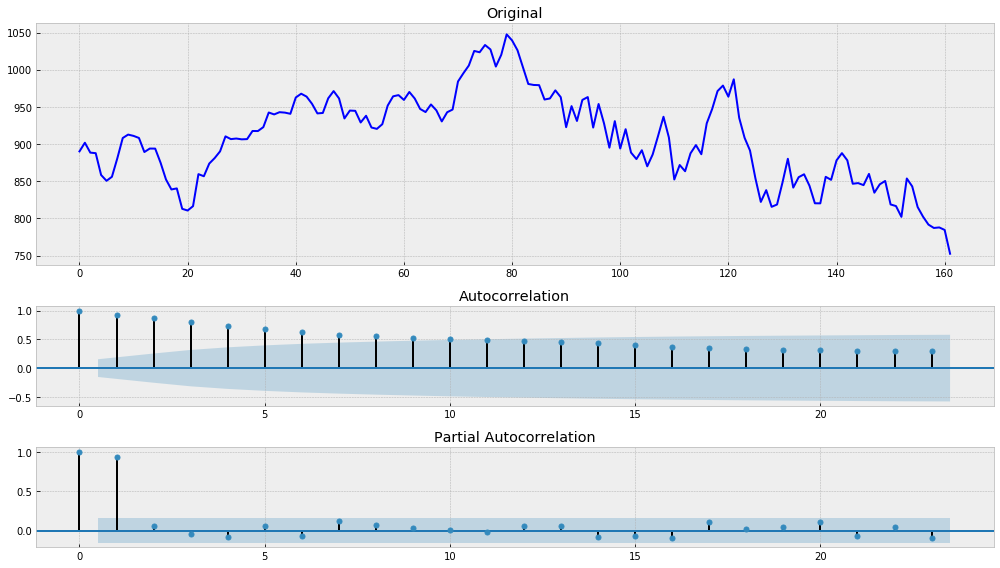

In [7]:
tsplot(dowjones_closing)

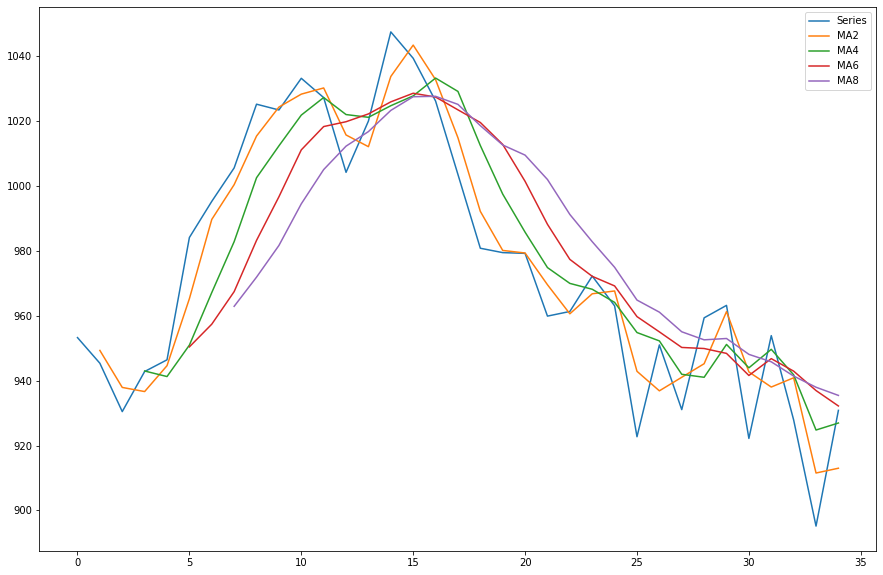

In [10]:
zoom = dowjones_closing[65:100]
plt.figure(figsize=(15,10))
idx = range(len(zoom))
plt.plot(idx,zoom,label='Series')
for period in range(2,9,2):
    plt.plot(idx,MA(zoom,period),label=f"MA{period}")
plt.legend()
plt.show()

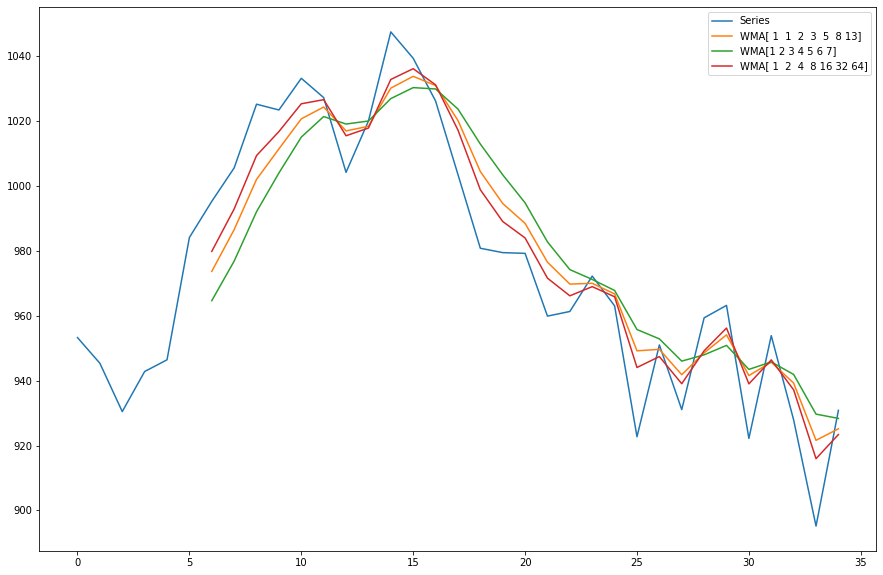

In [11]:
zoom = dowjones_closing[65:100]
plt.figure(figsize=(15,10))
idx = range(len(zoom))
plt.plot(idx,zoom,label='Series')
for weight in [np.array([1,1,2,3,5,8,13]),np.array([1,2,3,4,5,6,7]),np.array([1,2,4,8,16,32,64])]:
    plt.plot(idx,WMA(zoom,weight),label=f"WMA{weight}")
plt.legend()
plt.show()

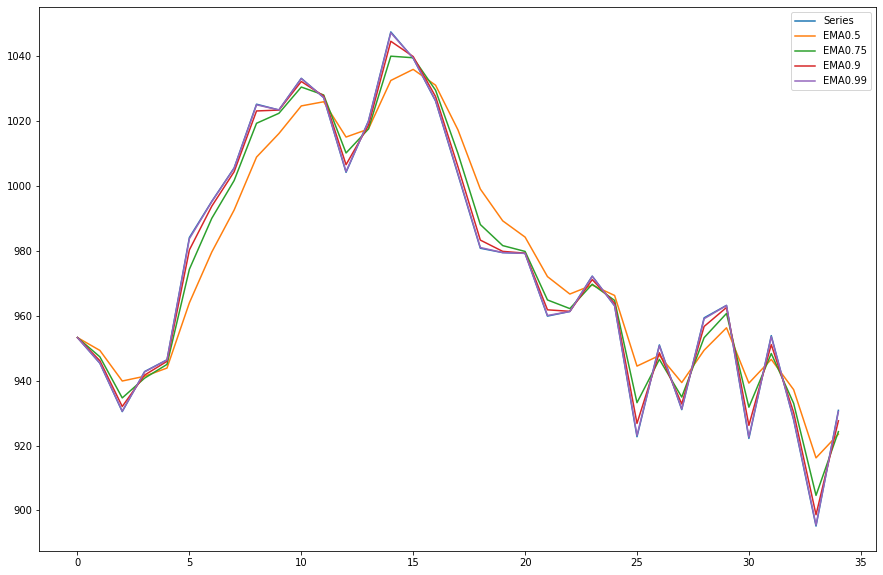

In [14]:
zoom = dowjones_closing[65:100].reset_index()['Close']
plt.figure(figsize=(15,10))
idx = range(len(zoom))
plt.plot(idx,zoom,label='Series')
for coef in [0.5,0.75,.9,.99]:
    plt.plot(idx,EMA(zoom,coef),label=f"EMA{coef}")
plt.legend()
plt.show()

In [15]:
predictions = {}
for period in range(2,9,2):
    predictions[f"MA{period}"] = MA(dowjones_closing,period)

for weight in [np.array([1,1,2,3,5,8,13]),np.array([1,2,3,4,5,6,7]),np.array([1,2,4,8,16,32,64])]:
    predictions[f"WMA{weight}"] = WMA(dowjones_closing,weight)
    
for coef in [0.5,0.75,.9,.99]:
    predictions[f"EMA{coef}"] = EMA(dowjones_closing,coef)

In [16]:
MSE = {}
for key,value in predictions.items():
    MSE[key] = np.sum(np.square(value - dowjones_closing))
MSE

{'MA2': 15795.257325000352,
 'MA4': 52755.73291249966,
 'MA6': 90830.92573888857,
 'MA8': 125078.9482171871,
 'WMA[ 1  1  2  3  5  8 13]': 33472.260775206596,
 'WMA[1 2 3 4 5 6 7]': 61169.098257653066,
 'WMA[ 1  2  4  8 16 32 64]': 19310.91574407591,
 'EMA0.5': 20211.760625729614,
 'EMA0.75': 4135.809648248289,
 'EMA0.9': 633.2811352570062,
 'EMA0.99': 6.313713205768527}

In [17]:
sorted(MSE.items(),key=lambda x: x[1])

[('EMA0.99', 6.313713205768527),
 ('EMA0.9', 633.2811352570062),
 ('EMA0.75', 4135.809648248289),
 ('MA2', 15795.257325000352),
 ('WMA[ 1  2  4  8 16 32 64]', 19310.91574407591),
 ('EMA0.5', 20211.760625729614),
 ('WMA[ 1  1  2  3  5  8 13]', 33472.260775206596),
 ('MA4', 52755.73291249966),
 ('WMA[1 2 3 4 5 6 7]', 61169.098257653066),
 ('MA6', 90830.92573888857),
 ('MA8', 125078.9482171871)]

Согласно метрике MSE лучшей моделью для нестационарного ряда является экспоненциальное скользящее среднее ЕМА0.99. 

# Стационарный ряд "Daily total female births in California"

In [18]:
female_births = pd.read_csv("daily-total-female-births-in-cal.csv")["Count"]

Results of Dickey-Fuller Test:
Test Statistic                  -4.808291
p-value                          0.000052
#Lags Used                       6.000000
Number of Observations Used    358.000000
Critical Value (1%)             -3.448749
Critical Value (5%)             -2.869647
Critical Value (10%)            -2.571089
dtype: float64


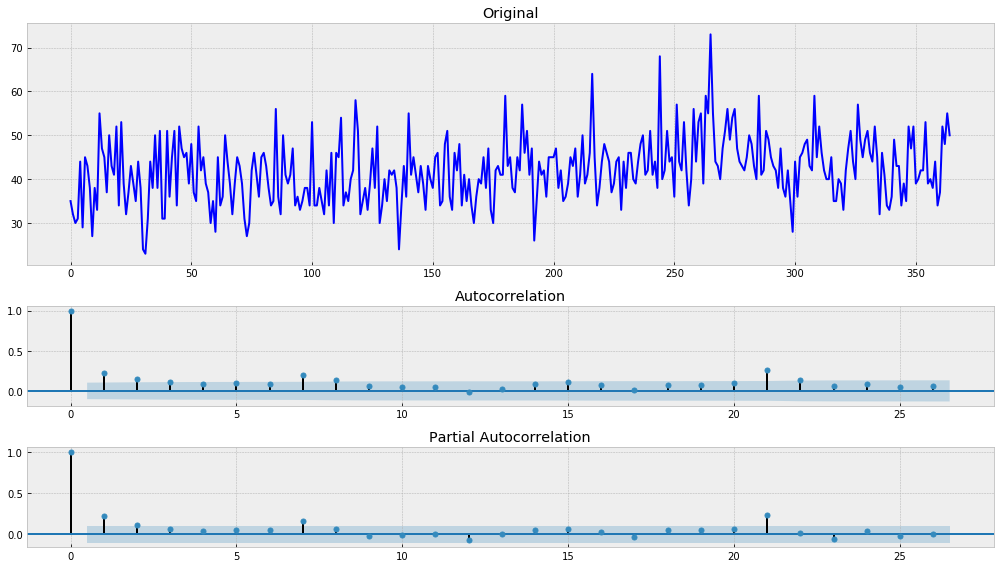

In [19]:
tsplot(female_births)

In [20]:
predictions = {}
for period in range(2,9,2):
    predictions[f"MA{period}"] = MA(female_births,period)

for weight in [np.array([1,1,2,3,5,8,13]),np.array([1,2,3,4,5,6,7]),np.array([1,2,4,8,16,32,64])]:
    predictions[f"WMA{weight}"] = WMA(female_births,weight)
    
for coef in [0.5,0.75,.9,.99]:
    predictions[f"EMA{coef}"] = EMA(female_births,coef)

In [22]:
MSE = {}
for key,value in predictions.items():
    MSE[key] = np.sum(np.square(value - female_births))
MSE

{'MA2': 7664.25,
 'MA4': 12498.3125,
 'MA6': 14207.944444444445,
 'MA8': 14533.546875,
 'WMA[ 1  1  2  3  5  8 13]': 7508.6299357208445,
 'WMA[1 2 3 4 5 6 7]': 11286.408163265307,
 'WMA[ 1  2  4  8 16 32 64]': 5272.445842891686,
 'EMA0.5': 5374.262176931346,
 'EMA0.75': 1566.866908176316,
 'EMA0.9': 280.93483005837606,
 'EMA0.99': 3.037634508289858}

In [23]:
sorted(MSE.items(),key=lambda x: x[1])

[('EMA0.99', 3.037634508289858),
 ('EMA0.9', 280.93483005837606),
 ('EMA0.75', 1566.866908176316),
 ('WMA[ 1  2  4  8 16 32 64]', 5272.445842891686),
 ('EMA0.5', 5374.262176931346),
 ('WMA[ 1  1  2  3  5  8 13]', 7508.6299357208445),
 ('MA2', 7664.25),
 ('WMA[1 2 3 4 5 6 7]', 11286.408163265307),
 ('MA4', 12498.3125),
 ('MA6', 14207.944444444445),
 ('MA8', 14533.546875)]

Согласно метрике MSE лучшей моделью для стационарного ряда также является экспоненциальное скользящее среднее ЕМА0.99. И ее результат еще улучшился в сравнении с нестационарным рядом. В целом все методы отработали лучще на стационарном ряду.